## Gathering

Importing packages for loading, gathering data and visualization

In [429]:
import pandas as pd
import requests
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

First source is `twitter-archive-enhanced.csv`. It had the major chunk of the data about tweets of the WeRateDogs account from 2015 to 2017.

In [430]:
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

In [431]:
archive_df.rating_numerator[46]

13

Second source is a file that was to be programmatically downloaded from the Udacity servers which had the results of the machine learning algorithm 'neural network' performed on the images from the WeRateDogs account. I downloaded this file using the Python library requests.

In [432]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get (url)

folder_name = 'image-predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
with open (os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)
    
img_predictions_df = pd.read_csv(folder_name + '/image-predictions.tsv', sep='\t')
img_predictions_df.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1587,798209839306514432,https://pbs.twimg.com/media/CxPPnCYWIAAo_ao.jpg,1,Pekinese,0.524583,True,Shih-Tzu,0.102931,True,Pomeranian,0.097893,True
130,668291999406125056,https://pbs.twimg.com/media/CUZABzGW4AE5F0k.jpg,1,web_site,0.995535,False,skunk,0.001363,False,badger,0.000686,False
1503,784826020293709826,https://pbs.twimg.com/media/CuRDF-XWcAIZSer.jpg,1,chow,0.090341,True,binoculars,0.083499,False,Irish_setter,0.077456,True


#### Using tweepy to access Twitter data

The third source for gathering data was `web scrapping off Twitter` using its Tweepy API using the tweet IDs found in the file at hand. The Tweepy API is an easy to use Python-based API which connects to a twitter account using secret and public keys. Once authenticated, one can easily scrap tweets off twitter.

In [433]:
'''
pip uninstall tweepy
pip install tweepy

import tweepy

consumer_key = 'xxx'
consumer_secret = 'xxx'
access_token = 'xxx'
access_secret = 'xxx'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth_handler=auth, 
                 wait_on_rate_limit=True, 
                 wait_on_rate_limit_notify=True)
'''

"\npip uninstall tweepy\npip install tweepy\n\nimport tweepy\n\nconsumer_key = 'xxx'\nconsumer_secret = 'xxx'\naccess_token = 'xxx'\naccess_secret = 'xxx'\n\nauth = tweepy.OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\n\napi = tweepy.API(auth_handler=auth, \n                 wait_on_rate_limit=True, \n                 wait_on_rate_limit_notify=True)\n"

In [434]:
'''
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = '1cnPviTkbmw2giXpDkDuel8SH'
consumer_secret = '9HUY76Wqq03rVHbWD0eDPaHqUTZ6EsmwDJYJHQNE1eoLedTEj7'
access_token = '3512981053-mSVpyPWwbLTLrDdWMCxKRef4xSYOLFpFCTz5Asx'
access_secret = 'MOAIdAgSm6eGVn1kSG3CQ4b61qOXJ2pYrhho35EEdqbVV'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
'''

'\nimport tweepy\nfrom tweepy import OAuthHandler\nimport json\nfrom timeit import default_timer as timer\n\n# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file\n# These are hidden to comply with Twitter\'s API terms and conditions\nconsumer_key = \'1cnPviTkbmw2giXpDkDuel8SH\'\nconsumer_secret = \'9HUY76Wqq03rVHbWD0eDPaHqUTZ6EsmwDJYJHQNE1eoLedTEj7\'\naccess_token = \'3512981053-mSVpyPWwbLTLrDdWMCxKRef4xSYOLFpFCTz5Asx\'\naccess_secret = \'MOAIdAgSm6eGVn1kSG3CQ4b61qOXJ2pYrhho35EEdqbVV\'\n\nauth = OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\n\napi = tweepy.API(auth, wait_on_rate_limit=True)\n\n# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:\n# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to\n# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv\n# NOTE TO REVIEWER: this student had mobile verification issues so the following\n# Twitter 

'''
tweet_ids = list(archive_df.tweet_id)

tweet_data = {}
for tweet in tweet_ids:
    try:
        tweet_status = api.get_status(tweet, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        tweet_data[str(tweet)] = tweet_status._json
        #print(tweet_ids.index(tweet) + 1, "/", "2354")
    except:
        print("Error for: " + str(tweet))
        #print(tweet_ids.index(tweet) + 1, "/", "2354")
'''

'''
with open('tweet_json.txt', 'w') as file:
    json.dump(tweet_data, file)
    
with open('tweet_json.txt') as file:
    data = json.load(file)
    
df_list = []

for tweet_id in data.keys():
    retweets = data[tweet_id]['retweet_count']
    favorites = data[tweet_id]['favorite_count']# + data[tweet_id]['favourites_count']
    df_list.append({'tweet_id': tweet_id,
                        'retweets': retweets,
                        'favorites': favorites})
    
tweets_df = pd.DataFrame(df_list, columns = ['tweet_id', 'retweets', 'favorites'])
tweets_df
'''

#### Read json file

Extract the required fields from each tweet's JSON data and store in a separate file, tweet_data_extra.csv, for use during the assessment phase.

In [435]:
#read JSON data from text file then store requierd info to a DataFrame 
tweet_json_data = []

In [436]:
# loop entire file 
with open('tweet_json.txt', 'r') as json_file:
    # read a line
    line = json_file.readline()
    # loop the line 
    while line:
        #store the line in `data` variable
        data = json.loads(line)
        # print(str(data))
        
         # extract variables from the JSON data
        data_id = data['id']
        data_retweet_count = data['retweet_count']
        data_favorite_count = data['favorite_count']
        created_at_tweet = data['created_at']
   
         # create a dictionary with the JSON data, then add to a list
        json_data = {'tweet_id': data_id, 
                     'retweet_count': data_retweet_count, 
                     'favorite_count': data_favorite_count,
                     'created_at': created_at_tweet
                    }
        
        tweet_json_data.append(json_data)

        # read the next line of JSON data
        line = json_file.readline()
        # ----- end while loop -----

In [437]:
# convert the tweet JSON data dictionary list to a DataFrame with 3 columns
df_tweet_data_extra = pd.DataFrame(tweet_json_data, 
                                   columns = ['created_at',
                                              'tweet_id',
                                              'retweet_count',
                                              'favorite_count'])

df_tweet_data_extra.head(5)

,created_at,tweet_id,retweet_count,favorite_count
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,8853,39467
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,6514,33819
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,4328,25461
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,8964,42908
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,9774,41048


In [438]:
# E the data frame
df_tweet_data_extra.to_csv('tweet_data_extra.csv', index = False)

## Assessing

Three dataframes:

- `tweets_df` which has retweet and favorite counts
- `img_predictions_df` has the results of a neural network trying to identify dog breed in a tweet's picture
- `archive_df` has the tweet's text, rating, and dog category

there were three different data sources, there had to be problems between the three files. The task at hand is finding and clean at least 8 data quality and two tidiness issues

In [439]:
img_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


tweet_id should be string
columns' name tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images)
rest columns aren't related to images tidiness issue

In [440]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [441]:
df_tweet_data_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
created_at        2354 non-null object
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3), object(1)
memory usage: 73.7+ KB


In [442]:
img_predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [443]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [444]:
df_tweet_data_extra.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [445]:
sum(archive_df.duplicated())

0

In [446]:
sum(img_predictions_df.duplicated())

0

In [447]:
archive_df.name.value_counts().head(5)

None       745
a          55 
Charlie    12 
Lucy       11 
Cooper     11 
Name: name, dtype: int64

In [448]:
archive_df.sample(5)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610513747968/photo/1,14,10,None,None,None,None,None
898,758854675097526272,NaN,NaN,2016-07-29 02:40:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Lilli Bee &amp; Honey Bear. Unfortunately, they were both born with no eyes. So heckin sad. Both 11/10 https://t.co/4UrfOZhztW",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/758854675097526272/photo/1,https://twitter.com/dog_rates/status/758854675097526272/photo/1,https://twitter.com/dog_rates/status/758854675097526272/photo/1,https://twitter.com/dog_rates/status/758854675097526272/photo/1",11,10,Lilli,None,None,None,None
2081,670822709593571328,NaN,NaN,2015-11-29 04:32:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Can't do better than this lol. 10/10 for the owner https://t.co/yrqGyMZhW6,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670822709593571328/photo/1,10,10,None,None,None,None,None
1308,707297311098011648,NaN,NaN,2016-03-08 20:09:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She can go from sweet to scary af in a matter of seconds. 10/10 points deducted for cats on pajamas https://t.co/B6dmZmJBdK,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/707297311098011648/photo/1,https://twitter.com/dog_rates/status/707297311098011648/photo/1",10,10,Cassie,None,None,None,None
105,872122724285648897,NaN,NaN,2017-06-06 16:07:15 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Kody. He's a baller. Wishes he was a little bit taller. Double dribbles often. Still 12/10 would happily get dunked on https://t.co/PKSpmiefwN,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/872122724285648897/photo/1,https://twitter.com/dog_rates/status/872122724285648897/photo/1",12,10,Kody,None,None,None,None


## Issues

### Tidiness issues

Tiddiness: issues with structure. Untidy data is also known as messy data.
Tidy data requirements:

( Each variable forms a column, Each observation forms a row, Each type of observational unit forms a table)

- Since one observation unit should be in one table and these three datasets are part of same observational unit. so all three datasets should be marged

`archive_df` table 
- dog stages in multiple columns
- We don't need rating_denominator column, all its values should be 10 
- Rename rating_numerator column to rating.
- Since we don't want retweets, we can drop all columns related to retweets: retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp.

### Quailty issues

Quality: issues with content. Low quality data is also known as dirty data.

`archive_df` table

- Remove not original tweets which is retweeted tweets
- `tweet_id` is int and `in_reply_to_status_id` and `in_reply_to_user_id` are float.
- `timestamp` is object
- dog stages(`doggo`, `floofer,pupper`,`puppo`) are object
- Dogs name incorrectly identified from available text
- incorrect dog names (a, an, the, just, one, very, quite, not, actually, mad, space, infuriating, all, officially, 0, old, life, unacceptable, my, incredibly, by, his, such)
- Extract the source of tweet, from iphone or others.
- Incorrect values in rating numerators
- Some tweets with rating_denominator NOT equal to 10
- Some tweets have wrong values extracted for rating; according the available text 
- Some tweets with rating_numerator >= 15.

`img_predictions_df` table
- `tweet_id` column is int

## Cleaning

In [449]:
### let us make a copy the original dataframe
archive_clean = archive_df.copy()
tweets_clean = df_tweet_data_extra.copy()
img_pred_clean = img_predictions_df.copy()

### Tidiness Issues
Best practies, start solving tidiness issues

#### Issue ( 1 ) -  All three datasets should be marged
##### Define

Merge the `tweets_df` and `img_predictions`tables to the `archive_df` table, joining on *tweet_id*.

##### Code

In [450]:
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)
img_pred_clean.tweet_id = img_pred_clean.tweet_id.astype(str)
tweets_clean.tweet_id = tweets_clean.tweet_id.astype(str)

In [451]:
archive_clean.info()
img_pred_clean.info()
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), o

In [452]:
archive_clean = pd.merge(archive_clean, tweets_clean,
                        how = 'inner', on = 'tweet_id')
archive_clean = pd.merge(archive_clean, img_pred_clean,
                        how = 'inner', on = 'tweet_id')

##### Test

In [453]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 31 columns):
tweet_id                      2073 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null object
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
doggo                         2073 non-null object
floofer                       2073 non-null object
pupper                        2073 non-null object
puppo                         2073 non-null object
created_at                    2073

In [454]:
archive_clean.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
712,761004547850530816,NaN,NaN,2016-08-04 01:03:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bo and Ty. Bo eats paper and Ty felt left out. 11/10 for both https://t.co/1acHQS8rvK,NaN,NaN,NaN,https://twitter.com/dog_rates/status/761004547850530816/photo/1,...,1,golden_retriever,0.735163,True,Sussex_spaniel,0.064897,True,Labrador_retriever,0.047704,True
917,733109485275860992,NaN,NaN,2016-05-19 01:38:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",NaN,NaN,NaN,https://twitter.com/dog_rates/status/733109485275860992/photo/1,...,1,golden_retriever,0.945523,True,Labrador_retriever,0.042319,True,doormat,0.003956,False
1729,672264251789176834,NaN,NaN,2015-12-03 04:01:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Kreg. He has the eyes of a tyrannical dictator. Will not rest until household is his. 10/10 https://t.co/TUeuaOmunV,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672264251789176834/photo/1,...,1,Chihuahua,0.609860,True,teddy,0.068134,False,Norwich_terrier,0.059227,True


#### Issue ( 2 ) - in `archive_df` table dog stages in multiple columns
##### Define

I avoid using **melt** function because it had caused the number of rows to be three times as large. So, I combine dog stage columns into single column(doggo, floofer, floofer, and puppo)using **loc**

In [455]:
# Number of rows are 2073
archive_clean.shape

(2073, 31)

##### Code

In [456]:
# convert 'None' or np.NaN to empty string "" 

archive_clean.doggo.replace('None', '', inplace=True)
archive_clean.doggo.replace(np.NaN, '', inplace=True)

In [457]:
#use loc to add a new column dog_stage = doggo, floofer, pupper or poppo. NaN will be used if not any of the previous

archive_clean.loc[archive_clean['doggo'] == 'doggo', 'dog_stage'] = 'doggo'
archive_clean.loc[archive_clean['floofer'] == 'floofer', 'dog_stage'] = 'floofer'
archive_clean.loc[archive_clean['pupper'] == 'pupper', 'dog_stage'] = 'pupper'
archive_clean.loc[archive_clean['puppo'] == 'puppo', 'dog_stage'] = 'puppo'

In [458]:
#Drop doggo, floofer,  pupper , and  puppo columns 
archive_clean = archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1)


##### Test

In [459]:
archive_clean.dog_stage.value_counts()

pupper     221
doggo      67 
puppo      24 
floofer    8  
Name: dog_stage, dtype: int64

In [460]:
# Number of rows are the same after merging the columns  
archive_clean.shape

(2073, 28)

### Quailty Issues

#### Issue (1) - 1.	Remove not original tweets which is retweeted tweets

##### Define
Identify retweet tweets using  `retweeted_status_id` column. then drop them

In [461]:
# There are 79 tweets 
# retweeted_status_id + retweeted_status_user_id + retweeted_status_timestamp are 79

archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 28 columns):
tweet_id                      2073 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null object
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
created_at                    2073 non-null object
retweet_count                 2073 non-null int64
favorite_count                2073 non-null int64
jpg_url                       2073 non-null object
img_num                       2073 n

##### Code

In [462]:
archive_clean = archive_clean[archive_clean.retweeted_status_id.isna()]

##### Test

In [463]:
# All retweet tweets are removed
# retweeted_status_id + retweeted_status_user_id + retweeted_status_timestamp are zero
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 28 columns):
tweet_id                      1994 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null object
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
created_at                    1994 non-null object
retweet_count                 1994 non-null int64
favorite_count                1994 non-null int64
jpg_url                       1994 non-null object
img_num                       1994 non-

#### Issue ( 2 ) - Wrong data type for columns 
##### Define

convert data type of below columns to Object
- `tweet_id`,`in_reply_to_status_id` and `in_reply_to_user_id` 

##### Code

In [464]:
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)
archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.astype(str)
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.astype(str)

##### Test

In [465]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 28 columns):
tweet_id                      1994 non-null object
in_reply_to_status_id         1994 non-null object
in_reply_to_user_id           1994 non-null object
timestamp                     1994 non-null object
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
created_at                    1994 non-null object
retweet_count                 1994 non-null int64
favorite_count                1994 non-null int64
jpg_url                       1994 non-null object
img_num                       1994 no

#### Issue ( 3 ) - dog categories are object (archive_df) 
##### Define

convert `dog_stage` column to categorical type

##### Code

In [466]:
archive_clean.dog_stage = archive_clean.dog_stage.astype('category')

##### Test

In [467]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 28 columns):
tweet_id                      1994 non-null object
in_reply_to_status_id         1994 non-null object
in_reply_to_user_id           1994 non-null object
timestamp                     1994 non-null object
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
created_at                    1994 non-null object
retweet_count                 1994 non-null int64
favorite_count                1994 non-null int64
jpg_url                       1994 non-null object
img_num                       1994 no

#### Issue ( 4 ) -  'timestamp' and 'retweeted_status_timestamp' columns are object variables 
##### Define
Convert object variables (`timestamp` and `retweeted_status_timestamp`) to datetim

##### Code

In [468]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)
archive_clean.retweeted_status_timestamp = pd.to_datetime(archive_clean.retweeted_status_timestamp)
archive_clean.created_at = pd.to_datetime(archive_clean.created_at)

##### Test

In [469]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 28 columns):
tweet_id                      1994 non-null object
in_reply_to_status_id         1994 non-null object
in_reply_to_user_id           1994 non-null object
timestamp                     1994 non-null datetime64[ns, UTC]
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
created_at                    1994 non-null datetime64[ns, UTC]
retweet_count                 1994 non-null int64
favorite_count                1994 non-null int64
jpg_url                       1994 non-null object
img

#### Issue ( 5 ) -  Retweets and favorites columns have NaNs values
##### Define
Fill NaNs with median values and convert their data types to int

##### Code

In [470]:
# Get median value using Numby library for two columns after dropping the rows that has Nans rows in retweet_count and favorite_count colimns.
median_retweet = np.median(archive_clean.retweet_count.dropna())
median_favorite = np.median(archive_clean.favorite_count.dropna())
print(median_retweet, median_favorite)

1359.5 4136.0


In [471]:
# return their data type to int 
archive_clean.retweet_count = archive_clean.retweet_count.fillna(median_retweet).astype('int64')
archive_clean.favorite_count = archive_clean.favorite_count.fillna(median_favorite).astype('int64')

##### Test

In [472]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 28 columns):
tweet_id                      1994 non-null object
in_reply_to_status_id         1994 non-null object
in_reply_to_user_id           1994 non-null object
timestamp                     1994 non-null datetime64[ns, UTC]
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
created_at                    1994 non-null datetime64[ns, UTC]
retweet_count                 1994 non-null int64
favorite_count                1994 non-null int64
jpg_url                       1994 non-null object
img

In [473]:
archive_clean.favorite_count.value_counts()

1691     3
2918     3
2176     3
345      3
2706     3
        ..
28469    1
6614     1
2520     1
475      1
4094     1
Name: favorite_count, Length: 1850, dtype: int64

In [474]:
archive_clean.favorite_count.value_counts()

1691     3
2918     3
2176     3
345      3
2706     3
        ..
28469    1
6614     1
2520     1
475      1
4094     1
Name: favorite_count, Length: 1850, dtype: int64

##### Test

#### Issue ( 6 ) - Dogs name incorrectly identified from available text
##### Define

correct dogs name with correct one from available text where available

##### Code

In [475]:
# To display all text without truncation
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

archive_clean.text[archive_clean.name =='all']
archive_clean.text[archive_clean.name =='incredibly']
archive_clean.text[archive_clean.name =='unacceptable']
archive_clean.text[archive_clean.name =='life']
archive_clean.text[archive_clean.name =='such']
archive_clean.text[archive_clean.name =='just']
archive_clean.text[archive_clean.name =='very']
archive_clean.text[archive_clean.name =='quite']
archive_clean.text[archive_clean.name =='actually']
archive_clean.text[archive_clean.name =='infuriating']
archive_clean.text[archive_clean.name =='officially']
archive_clean.text[archive_clean.name =='by']
archive_clean.text[archive_clean.name =='the']
archive_clean.text[archive_clean.name =='old']
archive_clean.text[archive_clean.name =='this']
archive_clean.text[archive_clean.name =='his']
archive_clean.text[archive_clean.name =='my']
archive_clean.text[archive_clean.name =='an']
archive_clean.text[archive_clean.name =='not']
archive_clean.text[archive_clean.name =='one']
archive_clean.text[archive_clean.name =='a']
archive_clean.text[archive_clean.name =='O']

624    This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC
Name: text, dtype: object

In [476]:
archive_clean.name[2066]= 'Rufus' 
archive_clean.name[2116]= 'Spork' 
archive_clean.name[2125]= 'Cherokee' 
archive_clean.name[2161]= 'Alfredo' 
archive_clean.name[2204]='Berta'
archive_clean.name[2034]= 'Jacob'
archive_clean.name[2218]= 'Chuk' 
archive_clean.name[2235]= 'Alfonso' 
archive_clean.name[2249]= 'Cheryl' 
archive_clean.name[2255]= 'Jessiga' 
archive_clean.name[2264]= 'Klint' 
archive_clean.name[2273]= 'Kohl' 
archive_clean.name[2304]= 'Pepe' 
archive_clean.name[2311]= 'Octaviath'  
archive_clean.name[852]='Zoey'
archive_clean.name[992]='Quizno'

archive_clean.name[1853]= 'Wylie'
archive_clean.name[1955]= 'Kip' 
archive_clean.name[2128]= 'Hemry' 
archive_clean.name[2146]= 'Alphred'
archive_clean.name[2287]= 'Daryl' 
archive_clean.name[2314]= 'Johm'
archive_clean.name[2191]= 'Leroi'

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### Test

In [477]:
archive_clean.name.value_counts()[:10]

None       545
a          55 
Charlie    11 
Cooper     10 
Oliver     10 
Lucy       10 
Tucker     9  
Penny      9  
Winston    8  
Sadie      8  
Name: name, dtype: int64

#### Issue ( 7 ) - incorrect dog names (a, an, the, just, one, very, quite, not, actually, mad, space, infuriating, all, officially, 0, old, life, unacceptable, my, incredibly, by, his, such) 
##### Define

Replace these dogs name with 'None'

##### Code

In [478]:
non_names = ['a', 'an', 'the', 'just', 'one', 'very', 'quite', 'not', 'actually', 
             'mad', 'space', 'infuriating', 'all', 'officially', '0', 'old', 'life',
             'unacceptable', 'my', 'incredibly', 'by', 'his', 'such']

for name in archive_clean.name:
    if name in non_names:
        archive_clean.name[archive_clean.name == name] = 'None'

##### Test

In [479]:
archive_clean.name.value_counts()[:10]

None       638
Charlie    11 
Lucy       10 
Cooper     10 
Oliver     10 
Penny      9  
Tucker     9  
Winston    8  
Sadie      8  
Lola       7  
Name: name, dtype: int64

#### Issue ( 8 ) - Extract the source of tweet, from iphone or others.
##### Define


##### Code

In [480]:
archive_clean['source']= archive_clean['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

##### Test

In [481]:
archive_clean.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
1267,691756958957883396,nan,nan,2016-01-25 22:58:05+00:00,Twitter for iPhone,THE BRITISH ARE COMING\nTHE BRITISH ARE COMING\n10/10 https://t.co/frGWV7IP6J,NaN,NaN,NaT,https://twitter.com/dog_rates/status/691756958957883396/photo/1,...,Saint_Bernard,0.342571,True,boxer,0.289096,True,Pembroke,0.076463,True,NaN
1756,671743150407421952,nan,nan,2015-12-01 17:30:22+00:00,Twitter for iPhone,This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,NaN,NaN,NaT,https://twitter.com/dog_rates/status/671743150407421952/photo/1,...,toy_poodle,0.419427,True,miniature_poodle,0.237067,True,swing,0.104193,False,NaN
1894,669216679721873412,nan,nan,2015-11-24 18:11:04+00:00,Twitter for iPhone,This is Clarq. He's a golden Quetzalcoatl. Clarq enjoys eating his own foot. Damn it Clarq. 8/10 would pet firmly https://t.co/d8ybynaRwZ,NaN,NaN,NaT,https://twitter.com/dog_rates/status/669216679721873412/photo/1,...,golden_retriever,0.992758,True,Irish_setter,0.003379,True,Saluki,0.001230,True,NaN


In [482]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 28 columns):
tweet_id                      1994 non-null object
in_reply_to_status_id         1994 non-null object
in_reply_to_user_id           1994 non-null object
timestamp                     1994 non-null datetime64[ns, UTC]
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
created_at                    1994 non-null datetime64[ns, UTC]
retweet_count                 1994 non-null int64
favorite_count                1994 non-null int64
jpg_url                       1994 non-null object
img

#### Issue ( 9 ) - Incorrect values in rating numerators
##### Define

Extract the correct rating from text column

In [483]:
# wrong extract rating_numerator from the text column
mask_cols = ['tweet_id', 'text', 'rating_numerator', 'rating_denominator']

archive_clean[archive_clean.tweet_id == '786709082849828864'][mask_cols]

,tweet_id,text,rating_numerator,rating_denominator
558,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10


##### Code

In [484]:
# Extract rating_numerator from the text using reugluer expresstion
ratings = archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)

# Check the rating_numerator for tweet id 786709082849828864
ratings[0][558]

'9.75'

In [485]:
# Edit rating_numerator with correct one
archive_clean.rating_numerator = ratings

# convert the data type
archive_clean.rating_numerator = archive_clean.rating_numerator.astype(float)

##### Test

In [486]:
# All rating_numerator is extracted probably and become float
archive_clean.sample(3)[mask_cols]

,tweet_id,text,rating_numerator,rating_denominator
621,776813020089548800,Meet Solomon. He was arrested for possession of adorable and attempted extra pats on the head. 12/10 would post bail https://t.co/nFqLaOLUQA,12.0,10
48,881906580714921986,This is Rey. He's a Benebop Cumberfloof. 12/10 dangerously pettable https://t.co/503CgWbhxQ,12.0,10
1210,697255105972801536,Meet Charlie. He likes to kiss all the big milk dogs with the rad earrings. Passionate af. 10/10 just a great guy https://t.co/Oe0XSGmfoP,10.0,10


In [487]:
# The tweet with ID 786709082849828864 is fixed
archive_clean[archive_clean.tweet_id == '786709082849828864'][mask_cols]

,tweet_id,text,rating_numerator,rating_denominator
558,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10


In [488]:
# Data type for rating_numerator column is converted to float
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 28 columns):
tweet_id                      1994 non-null object
in_reply_to_status_id         1994 non-null object
in_reply_to_user_id           1994 non-null object
timestamp                     1994 non-null datetime64[ns, UTC]
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null float64
rating_denominator            1994 non-null int64
name                          1994 non-null object
created_at                    1994 non-null datetime64[ns, UTC]
retweet_count                 1994 non-null int64
favorite_count                1994 non-null int64
jpg_url                       1994 non-null object
i

#### Issue ( 10 ) - Some tweets have wrong values extracted for rating; according the available text 
##### Define

Manual fix:

- 740373189193256964: replace 9/11 with 14/10
- 716439118184652801: replace 50/50 with 11/10
- 682962037429899265: replace 7/11 with 10/10
- 666287406224695296: replace 1/2 with 9/10

##### Code

In [407]:
archive_clean.rating_numerator [archive_clean.tweet_id =='740373189193256964']= 14
archive_clean.rating_denominator [archive_clean.tweet_id =='740373189193256964']= 10

archive_clean.rating_numerator [archive_clean.tweet_id =='716439118184652801']= 11
archive_clean.rating_denominator [archive_clean.tweet_id =='716439118184652801']= 10

archive_clean.rating_numerator [archive_clean.tweet_id =='682962037429899265']= 10
archive_clean.rating_denominator [archive_clean.tweet_id =='682962037429899265']= 10

archive_clean.rating_numerator [archive_clean.tweet_id =='666287406224695296']= 9
archive_clean.rating_denominator [archive_clean.tweet_id =='666287406224695296']= 10


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
//anaconda3/lib/python

##### Test

In [408]:
mask_cols = ['tweet_id', 'text', 'rating_numerator', 'rating_denominator']
archive_clean[(archive_clean.tweet_id == '740373189193256964') | \
              (archive_clean.tweet_id == '716439118184652801') | \
              (archive_clean.tweet_id == '682962037429899265') | \
              (archive_clean.tweet_id == '666287406224695296') ][mask_cols]

,tweet_id,text,rating_numerator,rating_denominator
876,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14.0,10
1001,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11.0,10
1405,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,10.0,10
2052,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,9.0,10


#### Issue ( 11) - Some tweets with rating_denominator NOT equal to 10
##### Define
Drop rows with rating_denominator greather than 10

In [409]:
# display the rating values in ascending oreder
archive_clean.rating_denominator.value_counts().sort_index(ascending = False)


170    1   
150    1   
130    1   
120    1   
110    1   
90     1   
80     2   
70     1   
50     2   
40     1   
20     1   
10     1980
7      1   
Name: rating_denominator, dtype: int64

##### Code

In [410]:
archive_clean = archive_clean[archive_clean.rating_denominator == 10]

##### Test

In [411]:
archive_clean.rating_denominator.value_counts().sort_index(ascending = False)

10    1980
Name: rating_denominator, dtype: int64

#### Issue ( 12 ) -  Some tweets with rating_numerator >= 15

##### Define
Drop tweets with rating_numerator >= 15, which either don't make sense or are huge

##### Code

In [412]:
# display the rating values in ascending oreder
archive_clean.rating_numerator.value_counts().sort_index(ascending = False)

1776.00    1  
420.00     1  
14.00      36 
13.50      1  
13.00      261
12.00      450
11.27      1  
11.26      1  
11.00      397
10.00      420
9.75       1  
9.00       151
8.00       95 
7.00       51 
6.00       32 
5.00       32 
4.00       15 
3.00       19 
2.00       9  
1.00       4  
0.00       2  
Name: rating_numerator, dtype: int64

In [413]:
archive_clean = archive_clean[archive_clean.rating_numerator <= 15]

##### Test

In [414]:
archive_clean.rating_numerator.value_counts().sort_index(ascending = False)

14.00    36 
13.50    1  
13.00    261
12.00    450
11.27    1  
11.26    1  
11.00    397
10.00    420
9.75     1  
9.00     151
8.00     95 
7.00     51 
6.00     32 
5.00     32 
4.00     15 
3.00     19 
2.00     9  
1.00     4  
0.00     2  
Name: rating_numerator, dtype: int64

### Tidiness Issues 

#### Issue ( 3 ) - We don't need rating_denominator column, since all its values is 10. Also, the rating_numerator column can be renamed rating.

##### Define
Drop the rating_denominator column.
Rename the rating_numerator column to be rating.

##### Code

In [415]:
archive_clean.rating_denominator.value_counts()


10    1978
Name: rating_denominator, dtype: int64

In [416]:
archive_clean.drop(['rating_denominator'], axis = 1, inplace = True)
archive_clean.rename(index = str, columns = {'rating_numerator': 'rating'}, inplace = True)

##### Test

In [417]:
list(archive_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating',
 'name',
 'created_at',
 'retweet_count',
 'favorite_count',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'dog_stage']

In [418]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1978 entries, 0 to 2072
Data columns (total 27 columns):
tweet_id                      1978 non-null object
in_reply_to_status_id         1978 non-null object
in_reply_to_user_id           1978 non-null object
timestamp                     1978 non-null datetime64[ns, UTC]
source                        1978 non-null object
text                          1978 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 1978 non-null object
rating                        1978 non-null float64
name                          1978 non-null object
created_at                    1978 non-null datetime64[ns, UTC]
retweet_count                 1978 non-null int64
favorite_count                1978 non-null int64
jpg_url                       1978 non-null object
img_num                       1978 non-null int64
p1    

#### Issue ( 4 ) - Since we don't want retweets, we can drop all columns related to retweets

##### Define
Drop columns `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`.

In [419]:
list(archive_clean.columns)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating',
 'name',
 'created_at',
 'retweet_count',
 'favorite_count',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'dog_stage']

##### Code

In [420]:
archive_clean = archive_clean.drop(['retweeted_status_id',
                                    'retweeted_status_user_id',
                                    'retweeted_status_timestamp'], axis = 1)

##### Test

In [421]:
list(archive_clean.columns)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating',
 'name',
 'created_at',
 'retweet_count',
 'favorite_count',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'dog_stage']

## Store

In [422]:
archive_clean.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

## Analysis

In [423]:
archive_clean['rating'].describe()

count    1978.000000
mean     10.554489  
std      2.180796   
min      0.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      14.000000  
Name: rating, dtype: float64

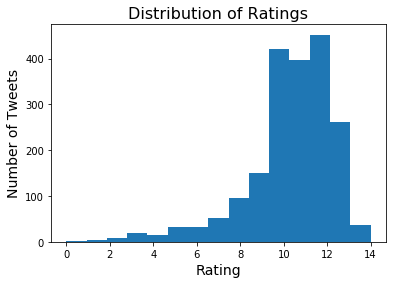

In [424]:
g= archive_clean['rating'].plot(kind = 'hist', bins = 15)

#plt.xlim(0, 15)
plt.ylabel('Number of Tweets', fontsize = 14)
plt.xlabel('Rating', fontsize = 14)
plt.title('Distribution of Ratings', fontsize = 16)
plt.show();

fig = g.get_figure()
fig.savefig('Histogram for Distribution of Rating.png')

The distribution of ratings is left skewed. From the descriptive statistics above we see that 75% of all ratings are between 10 and 14 inclusive (the IQR is from 10 to 12).



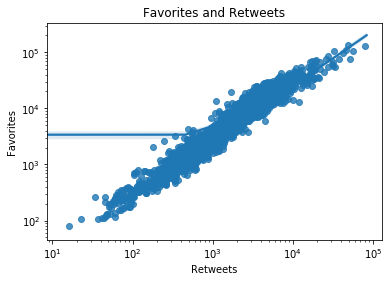

In [425]:
g = sns.regplot(x=archive_clean.retweet_count, y=archive_clean.favorite_count)
plt.title("Favorites and Retweets")
plt.xlabel('Retweets')
plt.ylabel('Favorites')

plt.yscale("log")
plt.xscale("log")

fig = g.get_figure()
fig.savefig('scatterplot for Favorites and Retweets.png')

In [426]:
np.corrcoef(archive_clean.retweet_count, archive_clean.favorite_count)

array([[1.        , 0.91297147],
       [0.91297147, 1.        ]])

In [427]:
archive_clean[['retweet_count','favorite_count']].describe()

,retweet_count,favorite_count
count,1978.000000,1978.000000
mean,2775.313448,8930.258342
std,4691.591664,12253.920209
min,16.000000,81.000000
25%,621.250000,1956.250000
50%,1350.000000,4136.000000
75%,3224.750000,11386.250000
max,79515.000000,132810.000000


There is a positive, strong relationship between favorite and retweet counts with correlation (r= 0.79). if the number of favorites increased for a tweet, the number of retweets can expect increased and vice versa.

In [428]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1978 entries, 0 to 2072
Data columns (total 24 columns):
tweet_id                 1978 non-null object
in_reply_to_status_id    1978 non-null object
in_reply_to_user_id      1978 non-null object
timestamp                1978 non-null datetime64[ns, UTC]
source                   1978 non-null object
text                     1978 non-null object
expanded_urls            1978 non-null object
rating                   1978 non-null float64
name                     1978 non-null object
created_at               1978 non-null datetime64[ns, UTC]
retweet_count            1978 non-null int64
favorite_count           1978 non-null int64
jpg_url                  1978 non-null object
img_num                  1978 non-null int64
p1                       1978 non-null object
p1_conf                  1978 non-null float64
p1_dog                   1978 non-null bool
p2                       1978 non-null object
p2_conf                  1978 non-null float64
